In [1]:
### methods to find the sulfate depostion ###
%run methods_sulfate_deposition.ipynb

/Users/feliciacarlborg/opt/anaconda3/lib/python3.8/site-packages/nbformat/__init__.py:92: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In [2]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scipy
import warnings 
from tabulate import tabulate
from scipy import interpolate
from scipy import signal
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
import itertools
from tqdm import tqdm
import seaborn as sns
import math
from matplotlib.widgets import Slider, RadioButtons
from scipy.stats.stats import pearsonr

np.set_printoptions(threshold=np.inf)
sns.set_theme(context='paper', style='white', palette='bright',font='arial')

## Bipolar Eruptions

In [3]:
exc_sheet_bp_mp = pd.ExcelFile('Bipolar match points ver 2022-12-23.xls')
bp_mp = pd.read_excel(exc_sheet_bp_mp, 'Sheet1')
bp_mp = np.array(bp_mp)

depth_bp_NGRIP = np.array(bp_mp[:,0], dtype='float64')
depth_bp_GISP2 = np.array(bp_mp[:,6], dtype='float64')

In [4]:
%%time
### Downloading the files from Excel ###
sheet6 = pd.ExcelFile('GISP2_IC_on_GICC05.xls')
GISP2 = pd.read_excel(sheet6, 'Sheet1')

GISP2

CPU times: user 274 ms, sys: 5.31 ms, total: 280 ms
Wall time: 280 ms


Depth_top(m)  Depth_bottom(m)  Na_ppb  NH4_ppb  K_ppb  Mg_ppb   Ca_ppb  \
0              2.59             3.79   4.598    3.241  1.017   0.984    6.212   
1              3.79             4.79   2.989    4.502  0.704   0.887    5.411   
2              4.79             5.79   5.977    3.421  1.486   0.936    4.409   
3              5.79             6.08   5.977   13.325  1.916   1.106    6.212   
4              6.08             7.21   6.667    5.042  1.095   2.042   11.222   
...             ...              ...     ...      ...    ...     ...      ...   
12183       3039.40          3039.60  26.570   10.230  4.320  16.640  123.060   
12184       3039.60          3039.80  26.030    9.130  4.010  15.560  115.210   
12185       3039.80          3040.00  25.830    7.930  3.510  14.620  108.130   
12186       3040.00          3040.20  23.980   10.480  3.680  13.890   95.780   
12187       3040.20          3040.32  27.700    7.930  4.310  14.480  115.930   

       Cl_ppb  NO3_ppb  SO4_ppb  NGRIP_depth(m)  Age_GICC05(b2k)  
0      17.372  140.131   73.004             NaN              NaN  
1      18.790  158.113  120.552             NaN              NaN  
2      17.017  117.809  108.545             NaN              NaN  
3      19.145  138.271  143.606             NaN              NaN  
4      22.690  146.332  134.481             NaN              NaN  
...       ...      ...      ...             ...              ...  
12183  43.040   73.940  115.150             NaN              NaN  
12184  42.940   73.140  110.210             NaN              NaN  
12185  43.290   73.720  109.110             NaN              NaN  
12186  39.810   72.080  100.510             NaN              NaN  
12187  44.400   66.170  114.210             NaN              NaN  

[12188 rows x 12 columns]

In [5]:
sheet7 = pd.ExcelFile('GRIP_and_GISP2_thinning_CH.xlsx')
thinning = pd.read_excel(sheet7, 'Sheet1')

thinning

Depth (m)  GRIP thinning  GISP2 thinning
0           25       1.000000        1.000000
1           30       0.998105        0.998089
2           35       0.995977        0.996182
3           40       0.993854        0.994278
4           45       0.991735        0.992378
..         ...            ...             ...
596       3005       0.000121        0.000357
597       3010       0.000078        0.000240
598       3015       0.000044        0.000159
599       3020       0.000019             NaN
600       3025       0.000003             NaN

[601 rows x 3 columns]

In [6]:
Sheet8 = pd.ExcelFile('GISP2_d18O_on_GICC05.xls')
d18O = pd.read_excel(Sheet8, 'Sheet1')

d18O

GISP2_depth_bottom(m)  d18O(permille)  NGRIP_depth(m)  Age_GICC05(b2k)
0                      2.135          -26.07             NaN              NaN
1                      2.200          -28.43             NaN              NaN
2                      2.265          -32.15             NaN              NaN
3                      2.330          -35.19             NaN              NaN
4                      2.395          -37.44             NaN              NaN
...                      ...             ...             ...              ...
21906               3039.400          -37.42             NaN              NaN
21907               3039.600          -37.47             NaN              NaN
21908               3039.800          -37.88             NaN              NaN
21909               3040.000          -37.27             NaN              NaN
21910               3040.200          -37.06             NaN              NaN

[21911 rows x 4 columns]

In [7]:
### Pandas to arrays ### 
GISP2 = np.array(GISP2)
thinning = np.array(thinning)
d18O = np.array(d18O)

### Retrieving different data sets ###
GISP2_age = GISP2[:,11]
GISP2_sulfate = GISP2[:,9]
GISP2_depth_top = GISP2[:,0]
GISP2_depth_bottom = GISP2[:,1]
GISP2_depth = ( GISP2_depth_top + GISP2_depth_bottom ) / 2
GISP2_thickness = GISP2_depth_bottom - GISP2_depth_top
GISP2_thinning = thinning[:,2]
GISP2_depth_thinning = thinning[:,0]
GISP2_d18O = d18O[:,1]
GISP2_d18O_age = d18O[:,3]
GISP2_d18O[np.where(GISP2_d18O == 999999)] = np.nan
GISP2_thinning_corr = np.interp(GISP2_depth, GISP2_depth_thinning, GISP2_thinning)

%store GISP2_thickness
%store GISP2_age
%store GISP2_depth_bottom
%store GISP2_thinning_corr
%store GISP2_depth
%store GISP2_thinning
%store GISP2_depth_thinning
%store GISP2_d18O 
%store GISP2_d18O_age 

Stored 'GISP2_thickness' (ndarray)
Stored 'GISP2_age' (ndarray)
Stored 'GISP2_depth_bottom' (ndarray)
Stored 'GISP2_thinning_corr' (ndarray)
Stored 'GISP2_depth' (ndarray)
Stored 'GISP2_thinning' (ndarray)
Stored 'GISP2_depth_thinning' (ndarray)
Stored 'GISP2_d18O' (ndarray)
Stored 'GISP2_d18O_age' (ndarray)


## Finding Accumulation rate 

0.02759895641232022 0.23902194954987935 0.08837170894551923


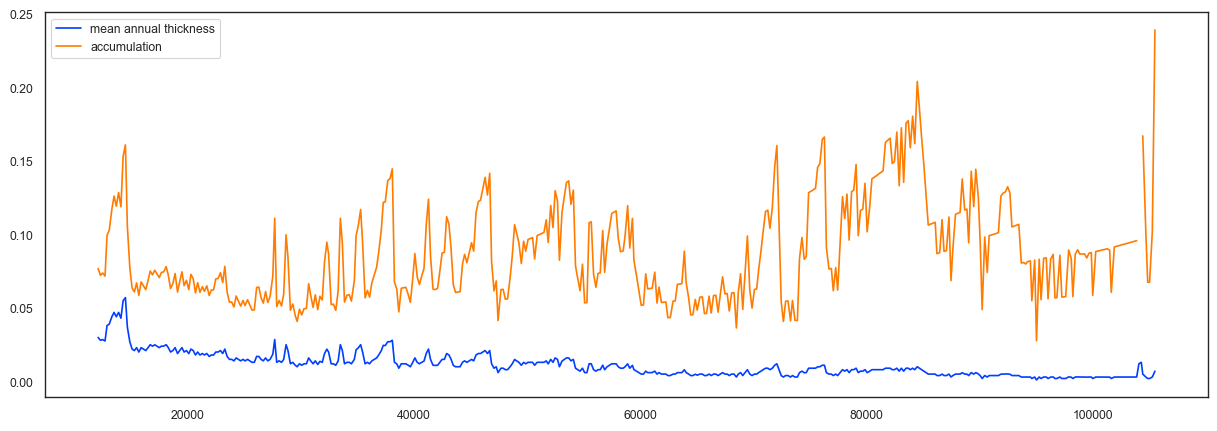

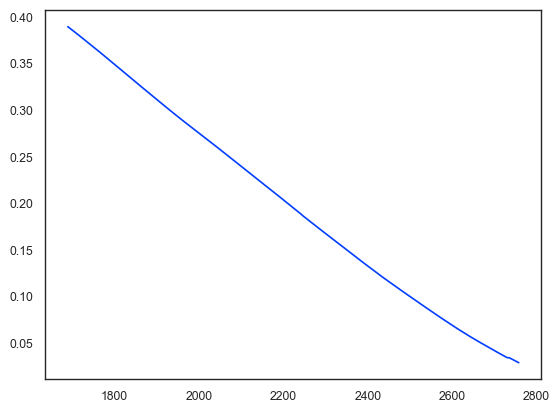

In [8]:
GISP2_age[~np.isnan(GISP2_age)][0], GISP2_age[~np.isnan(GISP2_age)][-1]

ann = 200
GISP2_annual = np.arange(10204, 105642,ann) #annual array
GISP2_annual_middle = np.arange(10214, 105642,ann)

GISP2_annual_thickness = np.zeros(len(GISP2_annual)) #20 year average 
depth_annual = np.zeros(len(GISP2_annual))
year = np.zeros(len(GISP2_annual))


for i in range(len(GISP2_annual)-1):
    idx = np.where( (GISP2_age > GISP2_annual[i]) & (GISP2_age < GISP2_annual[i+1]) )
    thickness_20yr = np.nansum(GISP2_thickness[idx])
    annual_20yr_mean_thickness = thickness_20yr/ann
    GISP2_annual_thickness[i] = annual_20yr_mean_thickness
    
    if len(idx[0]) == 0:
        continue
    else:

        idx_mid= int(idx[0][0] + (idx[0][-1]-idx[0][0])/2)
        depth_annual[i] = GISP2_depth[idx_mid]
        year[i] = GISP2_age[idx_mid]

depth_annual[depth_annual==0] = np.nan
GISP2_annual_thickness[GISP2_annual_thickness==0] = np.nan

thinning_corr = np.interp(depth_annual, GISP2_depth_thinning, GISP2_thinning)

lim_acc = np.where( (year > 12000) & (year<108000))

GISP2_acc = GISP2_annual_thickness/thinning_corr

GISP2_acc[GISP2_acc > 0.25] = np.nan

plt.figure(figsize=(15,5))
plt.plot(year[lim_acc], GISP2_annual_thickness[lim_acc], label='mean annual thickness')
plt.plot(year[lim_acc], GISP2_acc[lim_acc], label='accumulation')
plt.legend()

plt.figure()
plt.plot(depth_annual[lim_acc], thinning_corr[lim_acc])
#plt.plot(GISP2_depth_thinning[lim_acc], GISP2_thinning[lim_acc])

print(np.nanmin(GISP2_acc), np.nanmax(GISP2_acc), np.nanmean(GISP2_acc))

## Original GICC05 timescale from NGRIP - So that all depths correspond to the correct age 

In [9]:
## Downloading data
excel = pd.ExcelFile('2010-11-19 GICC05modelext for NGRIP 2.xls')
GICC05 = pd.read_excel(excel, 'GICC05')
GICC05= np.array(GICC05)

NGRIP_age_GICC05 = np.array(GICC05[70:, 0], dtype='float64')
NGRIP_depth_GICC05 = np.array(GICC05[70:, 1], dtype='float64')

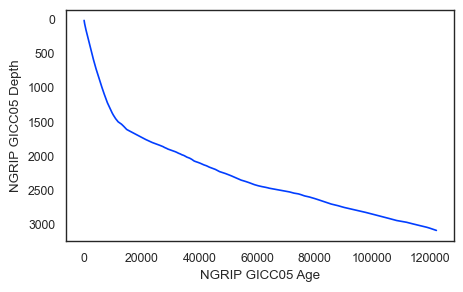

In [10]:
## This is the GICC05 timeseries that we want all our cores to be in. 
plt.figure(figsize=(5,3))
plt.plot(NGRIP_age_GICC05, NGRIP_depth_GICC05)
plt.xlabel('NGRIP GICC05 Age')
plt.ylabel('NGRIP GICC05 Depth')
plt.gca().invert_yaxis()

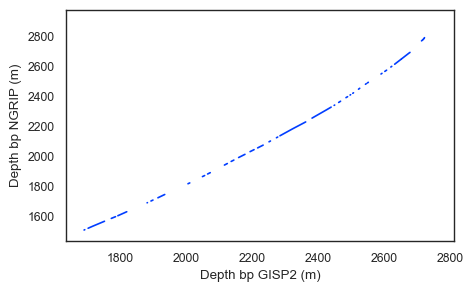

In [11]:
## This is along the points we want to start our first interpolation since they are connected.
plt.figure(figsize=(5,3)) 
plt.plot(depth_bp_GISP2, depth_bp_NGRIP)
plt.xlabel('Depth bp GISP2 (m)')
plt.ylabel('Depth bp NGRIP (m)')
plt.show()

In [12]:
#1. first interpolation. We want a new correspoding depth in NGRIP to fit the depth with GISP2. 
lim_GISP2 = np.where( (GISP2_depth > 1691) & (GISP2_depth < 2758) )
ip = interpolate.interp1d(depth_bp_GISP2, depth_bp_NGRIP, fill_value='extrapolate') ##interpolation so I get new depth for NGRIP
NGRIP_depth_new = ip(GISP2_depth[lim_GISP2])
##interpolating the nans for xp and fp since we want a smooth line to interpolate on. 

Text(0, 0.5, 'NGRIP depth (new)')

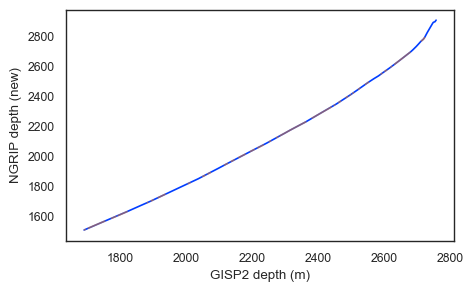

In [13]:
##The interpolated updated NGRIP depth 
plt.figure(figsize=(5,3))
plt.plot(GISP2_depth[lim_GISP2], NGRIP_depth_new )
plt.plot(depth_bp_GISP2, depth_bp_NGRIP, alpha=.5)
plt.xlabel('GISP2 depth (m)')
plt.ylabel('NGRIP depth (new)')

In [14]:
#2. Second interpolation. Getting the EDML GICC05 age correct (that corresponds to our updated NGRIP depth (that corresponds to the depth of GISP2))
GISP2_age_new = np.interp(NGRIP_depth_new, NGRIP_depth_GICC05, NGRIP_age_GICC05, left = np.nan, right = np.nan) ##Interpolation so I get the new age for GISP2

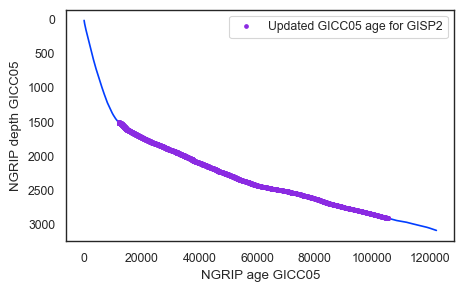

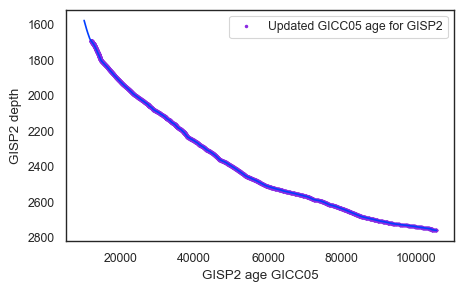

In [15]:
## The new GISP2 age vs the updated NGRIP depth (that corresponds to GISP2 depth)
plt.figure(figsize=(5,3))
plt.plot(NGRIP_age_GICC05, NGRIP_depth_GICC05)
plt.plot(GISP2_age_new, NGRIP_depth_new, 'm.', label='Updated GICC05 age for GISP2')
plt.ylabel('NGRIP depth GICC05')
plt.xlabel('NGRIP age GICC05')
plt.gca().invert_yaxis()
plt.legend()

##updated EDML age for corresponding original EDML depth 
plt.figure(figsize=(5,3))
plt.plot(GISP2_age_new, GISP2_depth[lim_GISP2], 'm.', label='Updated GICC05 age for GISP2', markersize=3)
plt.plot(GISP2_age, GISP2_depth)
plt.ylabel('GISP2 depth')
plt.xlabel('GISP2 age GICC05')
plt.gca().invert_yaxis()
plt.legend()

In [16]:
#storing the updated GISP2_age 
%store GISP2_age_new

GISP2_age = np.copy(GISP2_age_new)

Stored 'GISP2_age_new' (ndarray)


In [17]:
%matplotlib inline 

def age_interp(age):
    return np.arange(math.floor(age[~np.isnan(age)][0]), math.ceil(age[~np.isnan(age)][-1]),1)

GISP2_annual = age_interp(GISP2_d18O_age)

#print(GISP2_annual[0], GISP2_d18O_age[~np.isnan(GISP2_d18O_age)][0], GISP2_annual[-1], GISP2_d18O_age[~np.isnan(GISP2_d18O_age)][-1])

GISP2_annual_d18O = annual_average(GISP2_annual, GISP2_d18O_age[~np.isnan(GISP2_d18O_age)], GISP2_d18O[~np.isnan(GISP2_d18O_age)])

#for i in range(len(GISP2_d18O[~np.isnan(GISP2_d18O_age)])):
    #print('age =', GISP2_d18O_age[~np.isnan(GISP2_d18O_age)][i], 'd180=', GISP2_d18O[~np.isnan(GISP2_d18O_age)][i])

def temperature(d180):
    return (d180 + 13.7)/0.67

GISP2_temp = temperature(GISP2_annual_d18O)

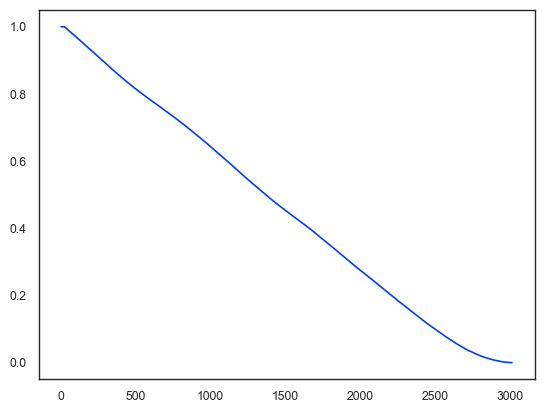

In [18]:
plt.figure()
plt.plot(GISP2_depth, GISP2_thinning_corr)

In [19]:
### Annual values ### 
GISP2_annual = np.arange(10204, 105642,1) #annual array
GISP2_age_list = np.arange(10*1e3,108*1e3,2000) #list with ages for the different intervals

In [20]:
%%time
GISP2_filt = 181 #filter length

#GISP2_annual_sulfate, GISP2_annual_thickness = annual_average(GISP2_annual, GISP2_age, GISP2_sulfate, GISP2_thickness)
#GISP2_annual_sulfate_interp = interp(GISP2_annual_sulfate)

GISP2_RM = running_median(GISP2_age, GISP2_sulfate[lim_GISP2], GISP2_filt)
GISP2_MAD = median_of_absolute_deviation(GISP2_age, GISP2_sulfate[lim_GISP2], GISP2_filt)
GISP2_excl_volc = exl_volcanism(GISP2_age, GISP2_sulfate[lim_GISP2], GISP2_filt,3)
GISP2_RRM = running_median(GISP2_age, GISP2_excl_volc, GISP2_filt)
GISP2_RMAD = median_of_absolute_deviation(GISP2_age, GISP2_excl_volc, GISP2_filt)

CPU times: user 1.97 s, sys: 4.63 ms, total: 1.98 s
Wall time: 1.98 s


In [21]:
%store GISP2_RRM
%store GISP2_RMAD

Stored 'GISP2_RRM' (ndarray)
Stored 'GISP2_RMAD' (ndarray)


In [22]:
thresholds = np.arange(.5,4.5,.5) #different volcanic thresholds 

all_RMAD_GISP2 = pd.DataFrame()
all_RRM_GISP2 = pd.DataFrame()

for i in range(len(thresholds)):
    GISP2_exl_volc_test = exl_volcanism(GISP2_age, GISP2_sulfate[lim_GISP2],GISP2_filt,thresholds[i])
    GISP2_RRM_test = running_median(GISP2_age, GISP2_exl_volc_test, GISP2_filt)
    GISP2_RMAD_test = median_of_absolute_deviation(GISP2_age,  GISP2_exl_volc_test, GISP2_filt, thresholds[i])
    all_RRM_GISP2[i] = GISP2_RRM_test
    all_RMAD_GISP2[i] = GISP2_RMAD_test

In [23]:
all_RRM_GISP2 = np.array(all_RRM_GISP2)
all_RMAD_GISP2 = np.array(all_RMAD_GISP2)

%store all_RMAD_GISP2
%store all_RRM_GISP2

Stored 'all_RMAD_GISP2' (ndarray)
Stored 'all_RRM_GISP2' (ndarray)


In [24]:
corr = pearsonr(GISP2_RRM[~np.isnan(GISP2_RRM)], all_RRM_GISP2[:,5][~np.isnan(GISP2_RRM)])

corr, len(GISP2_sulfate)

((1.0, 0.0), 12188)

In [25]:
lim_GISP2 = np.where((GISP2_depth > 1691) & (GISP2_depth < 2758)) ##so that we have depth for the correct age

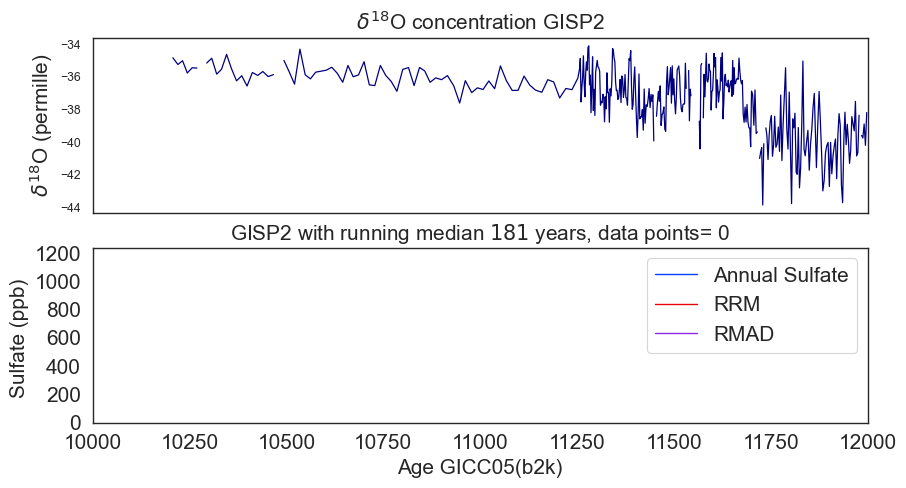

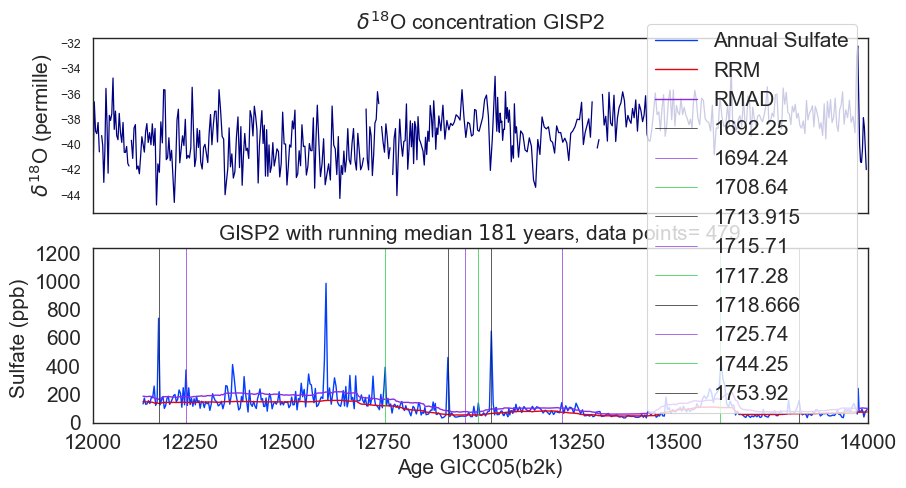

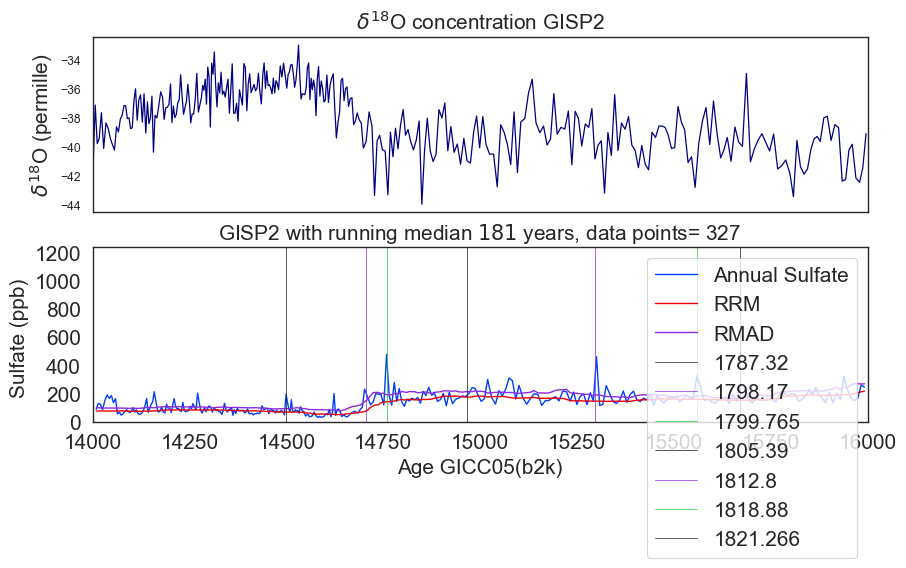

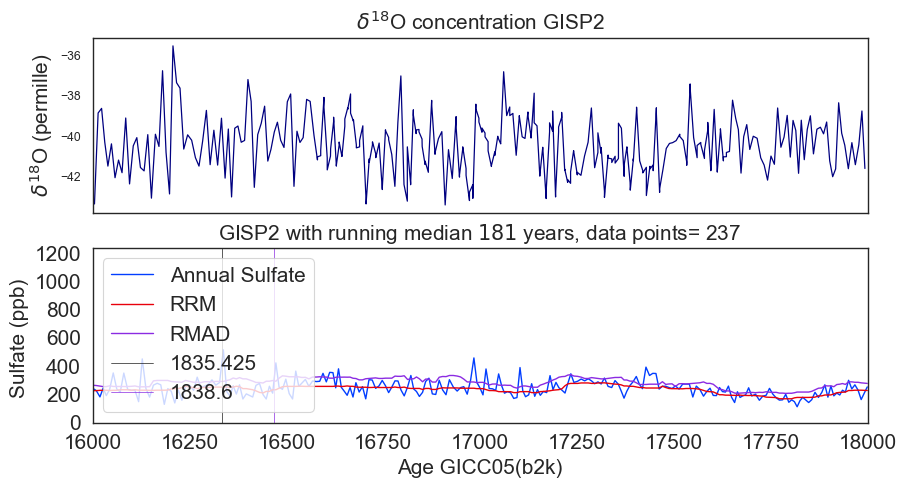

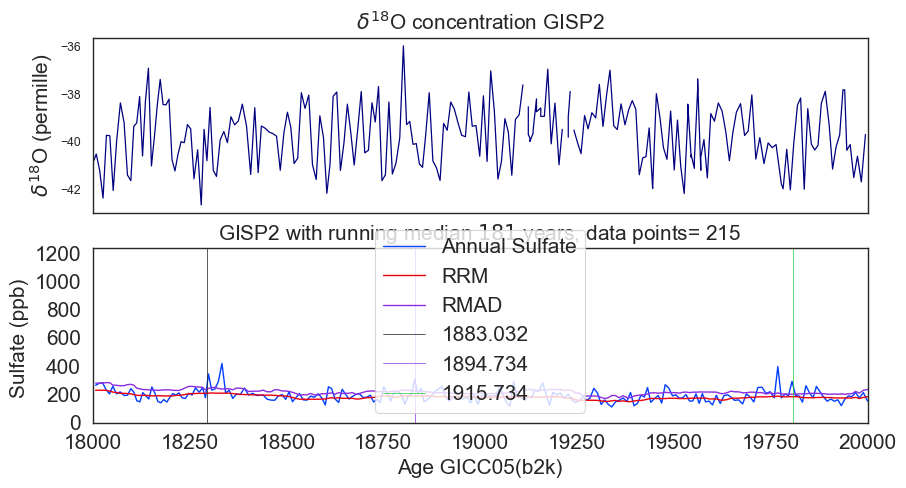

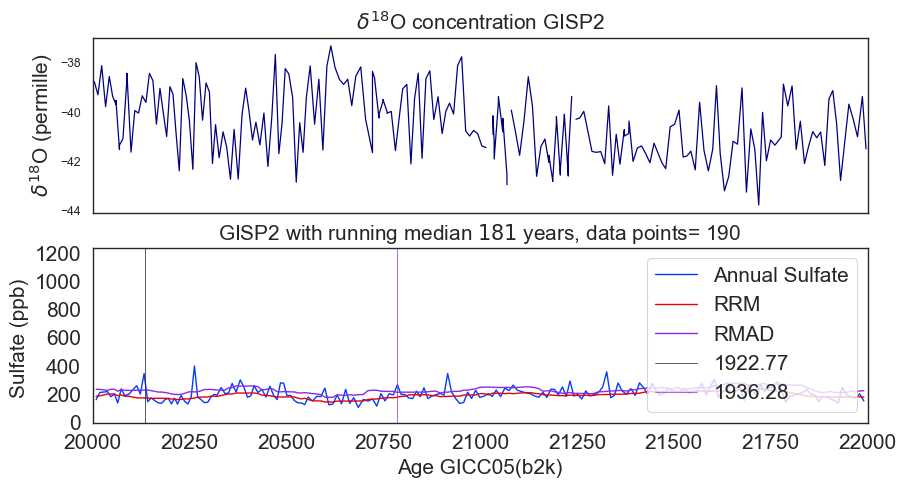

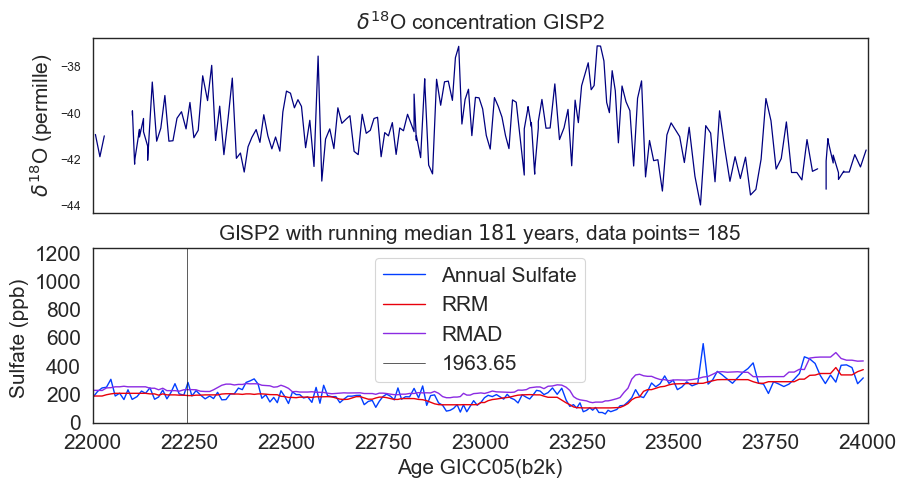

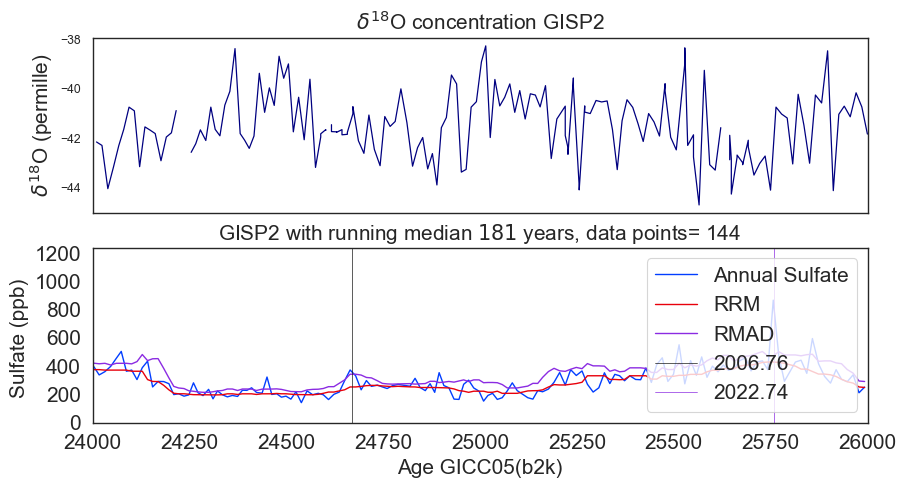

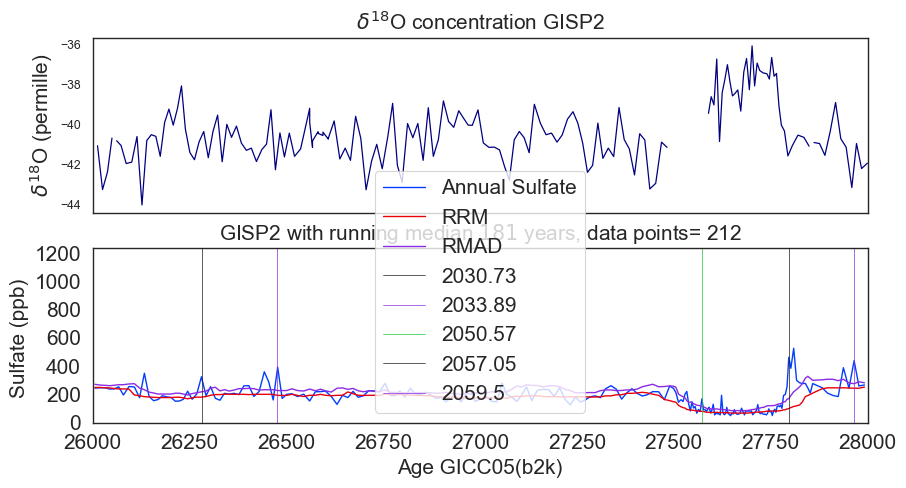

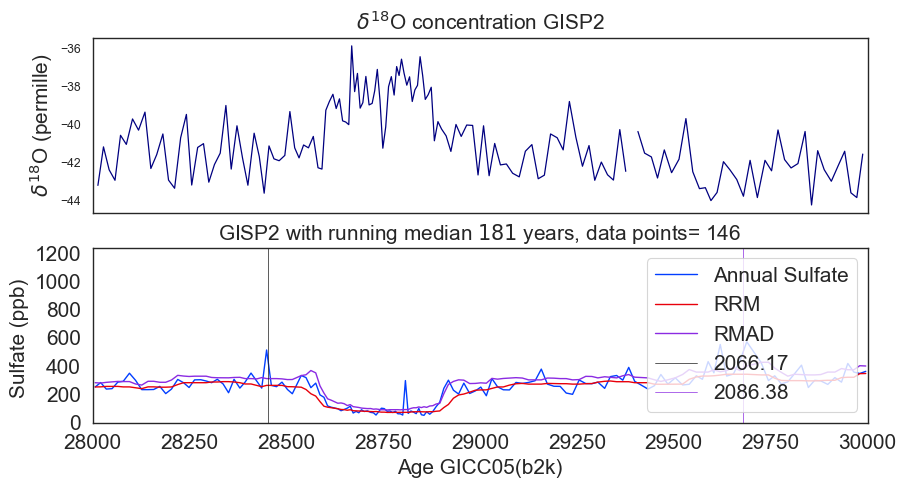

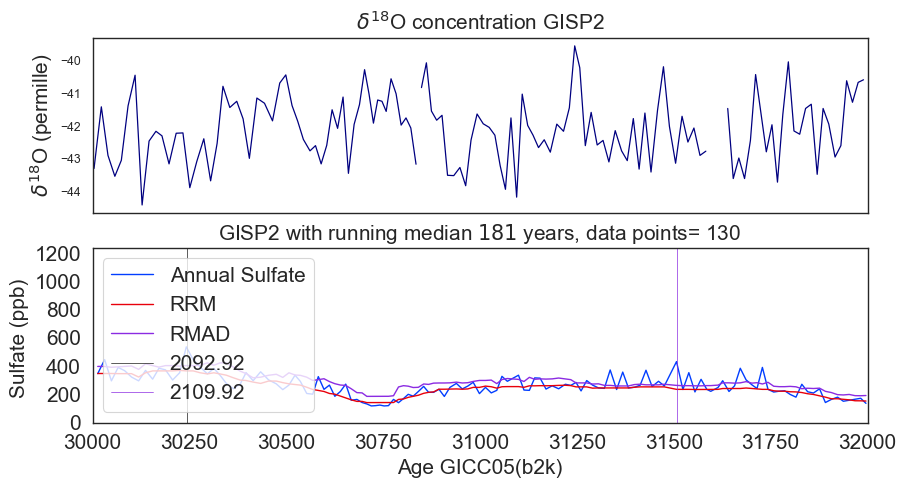

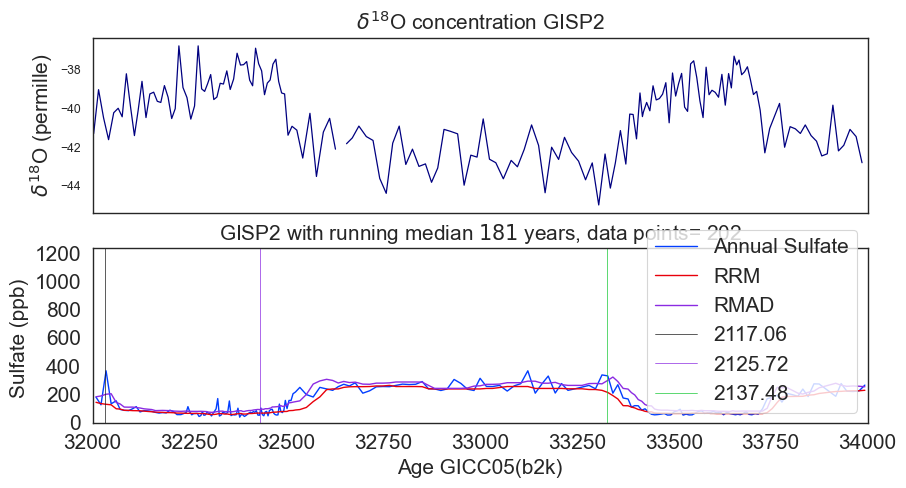

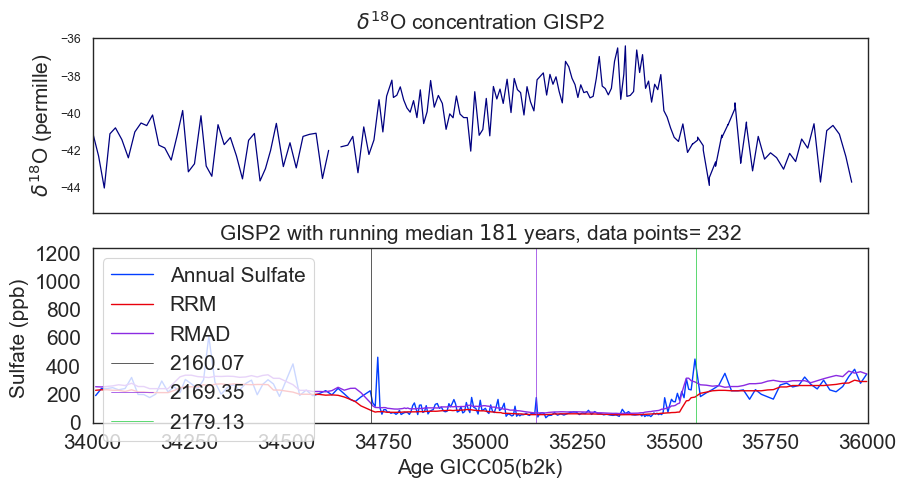

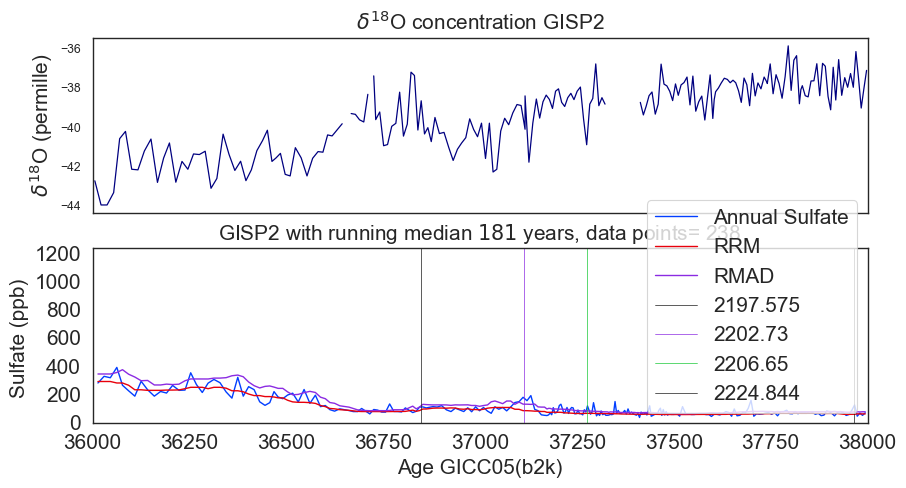

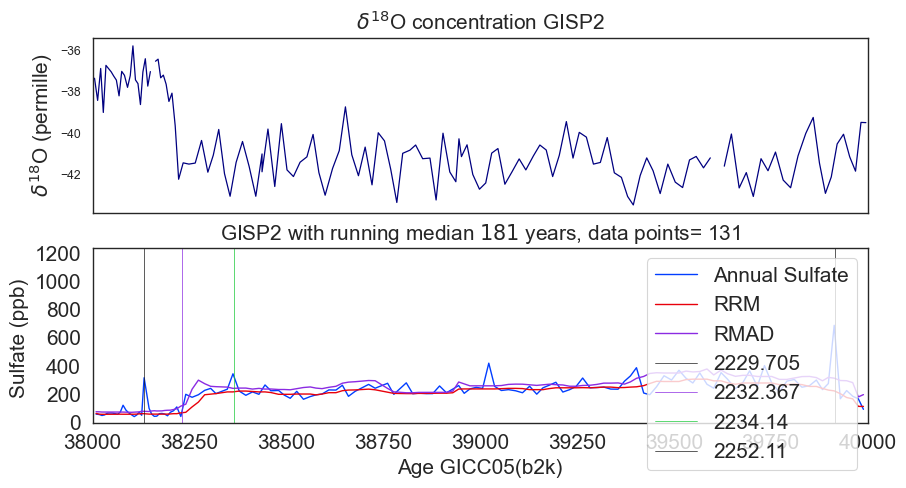

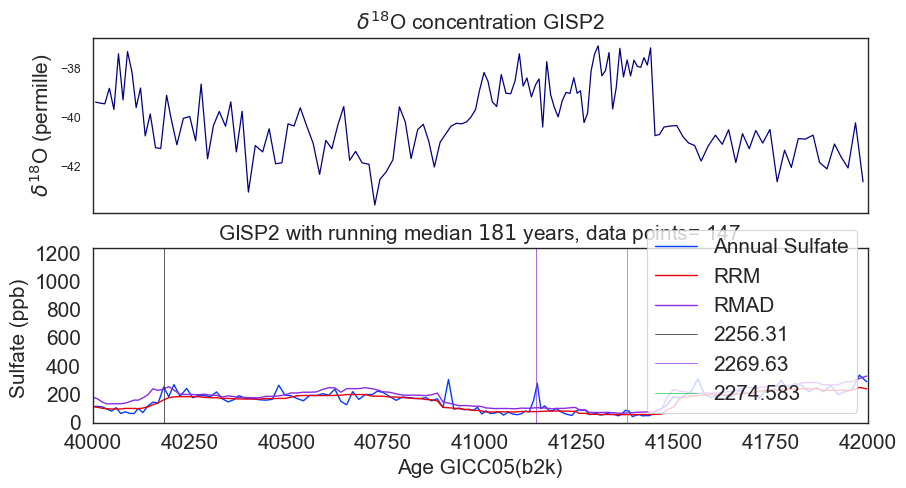

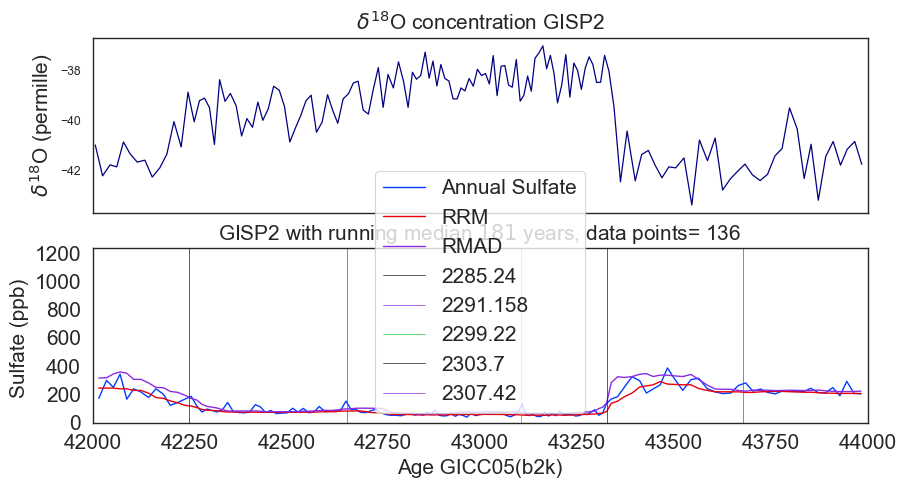

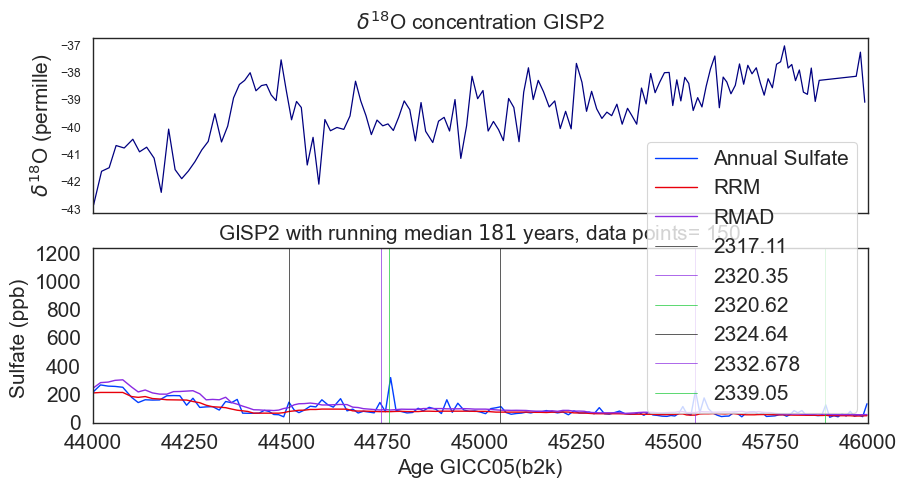

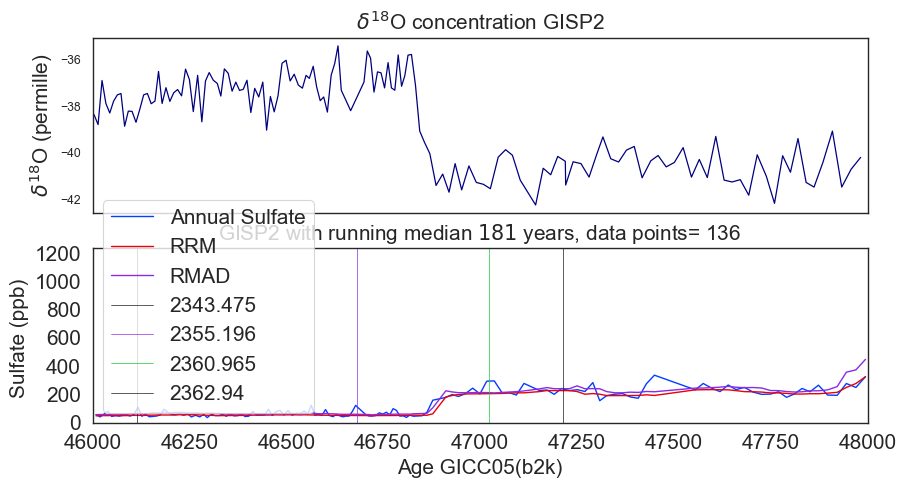

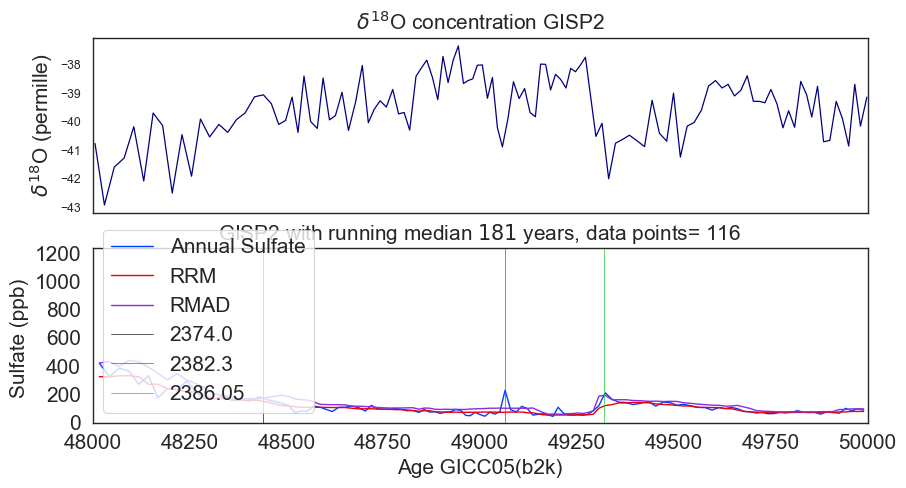

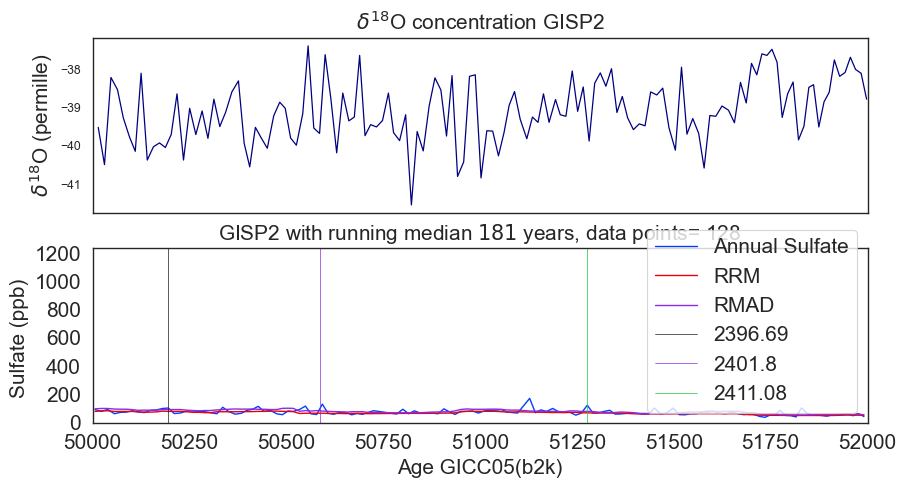

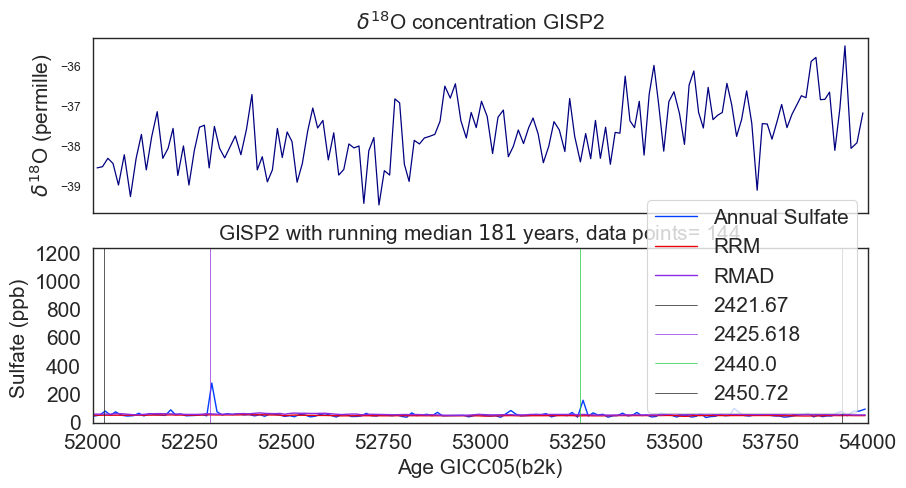

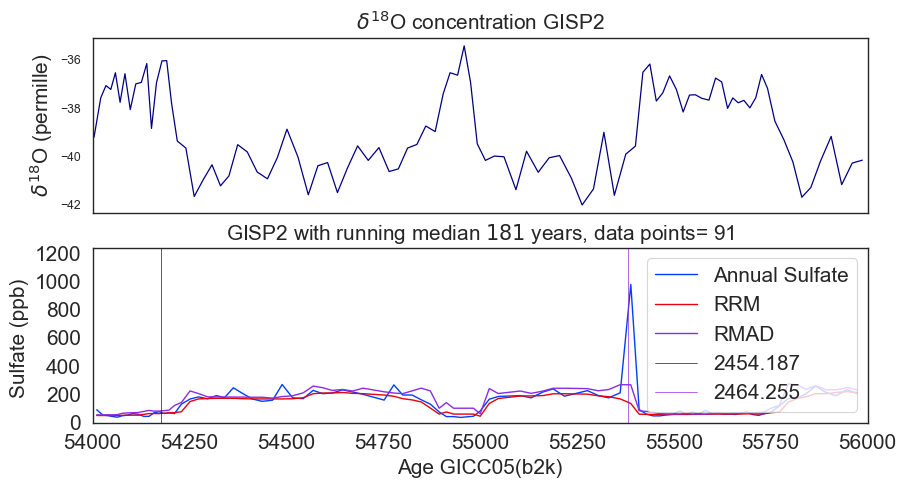

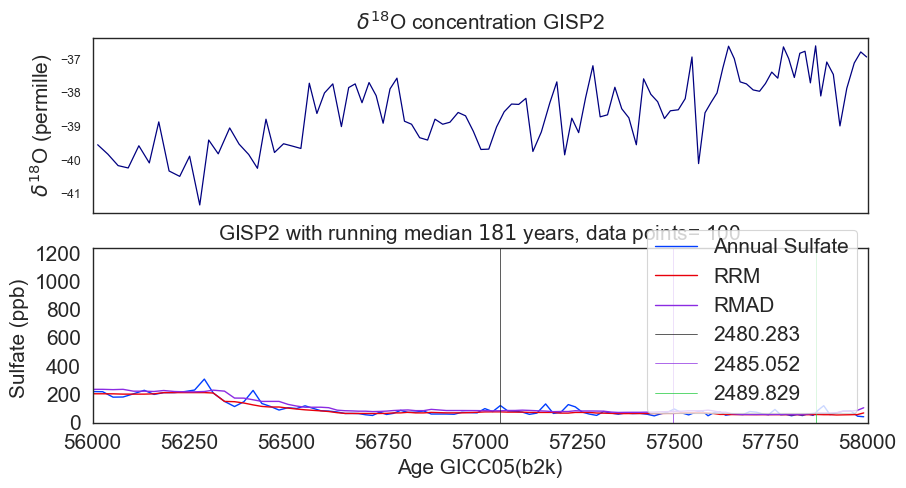

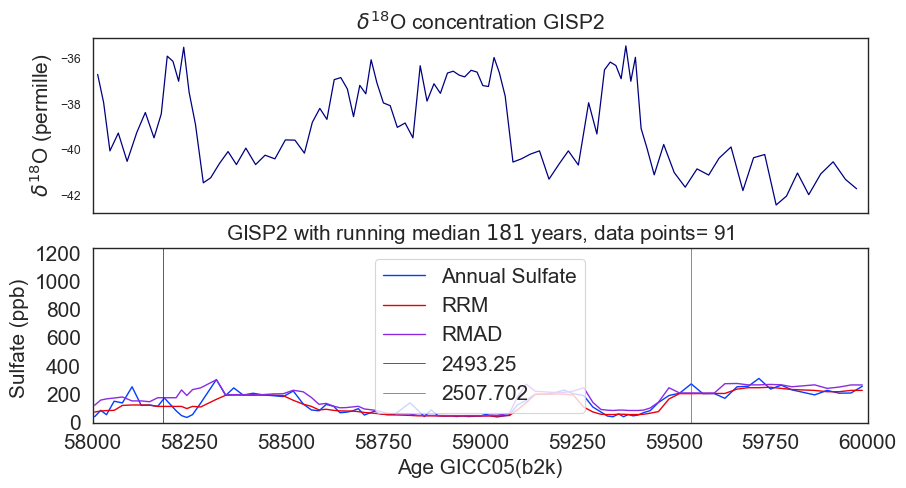

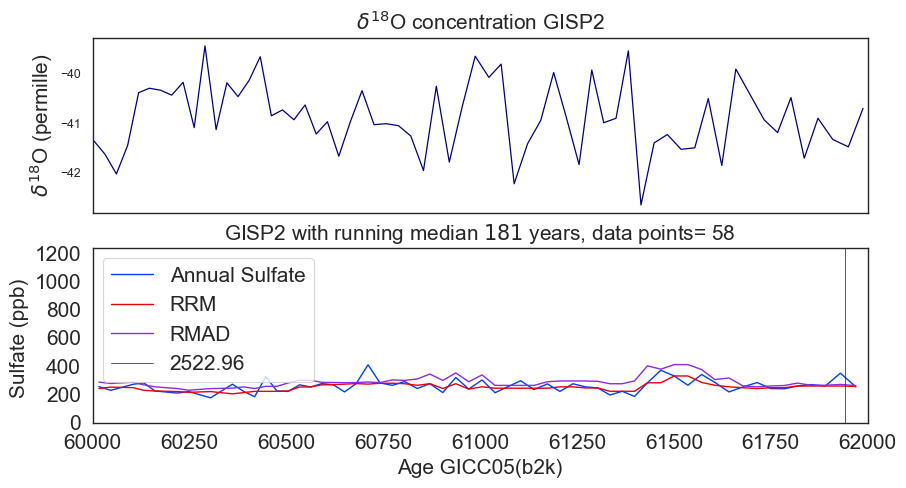

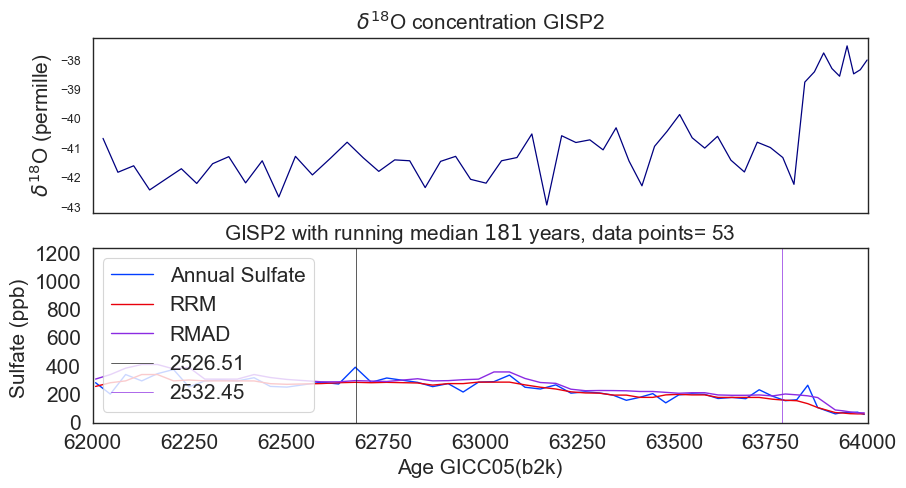

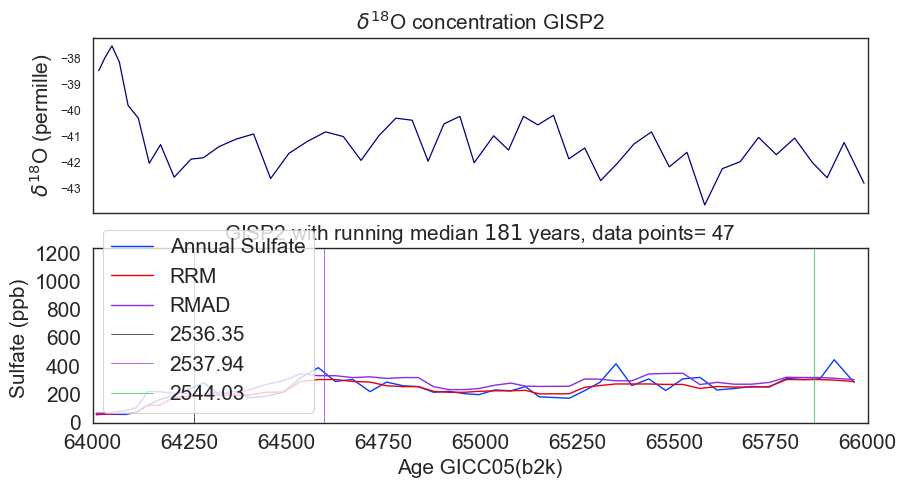

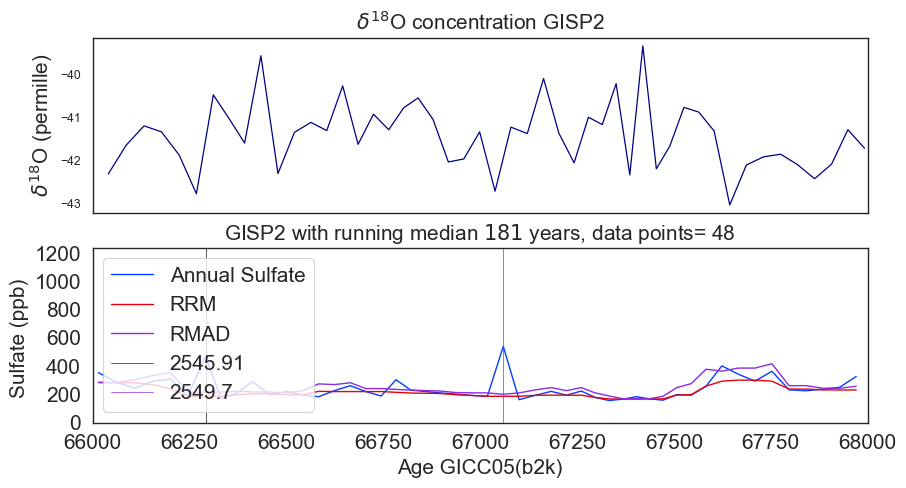

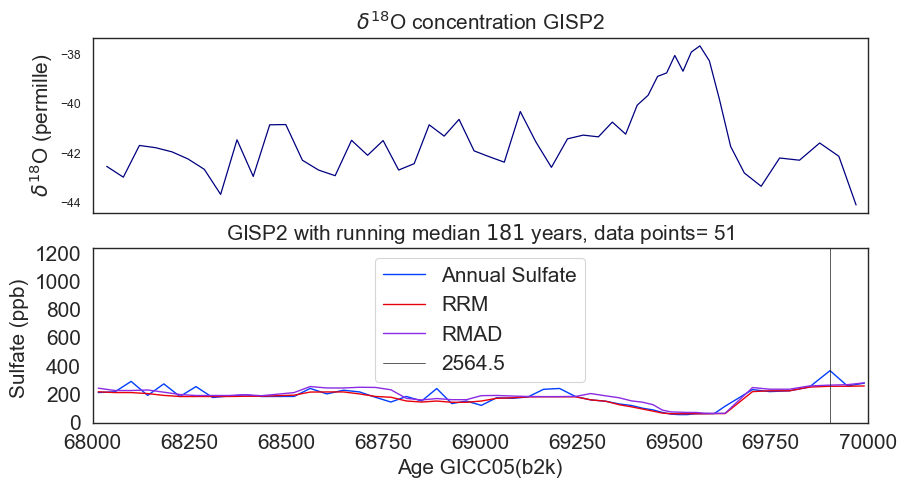

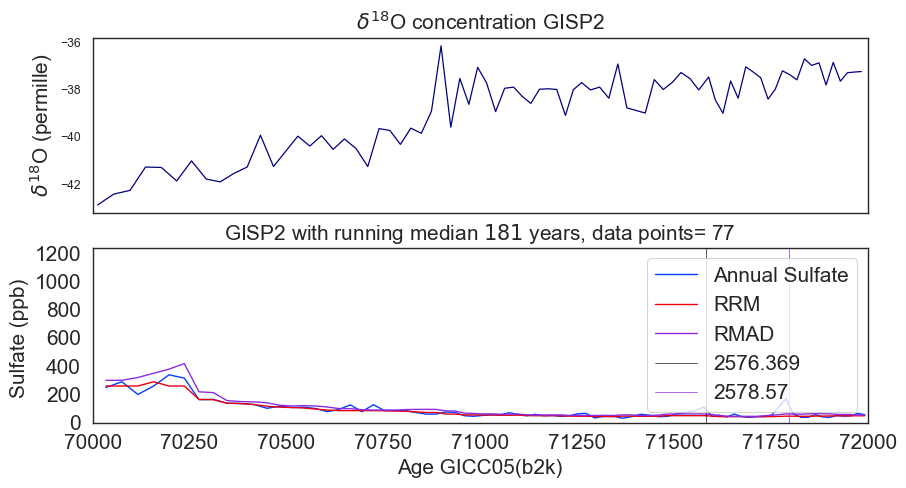

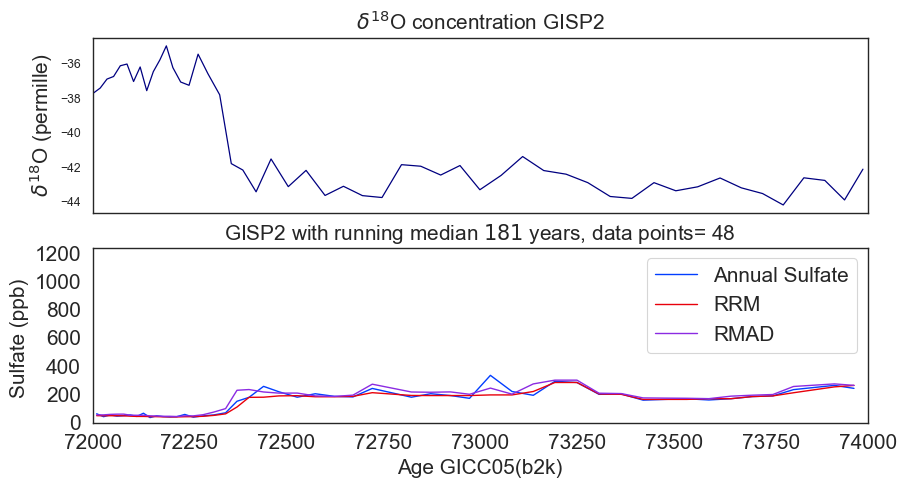

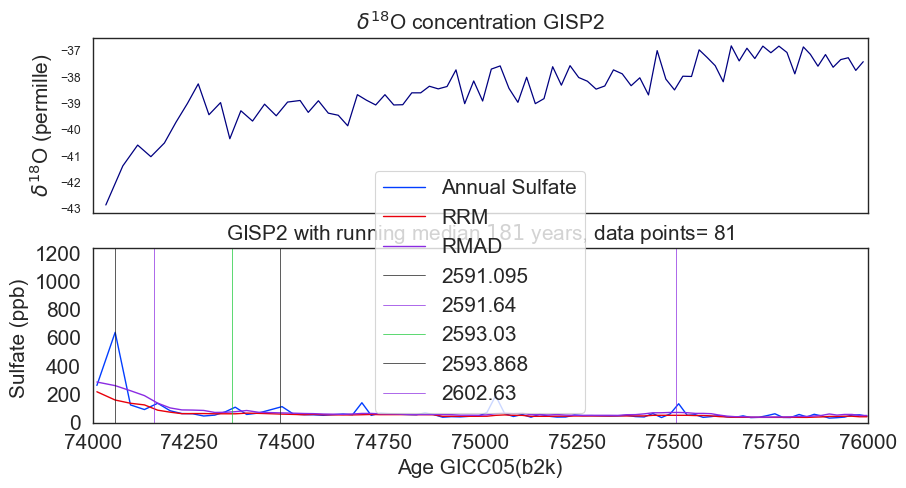

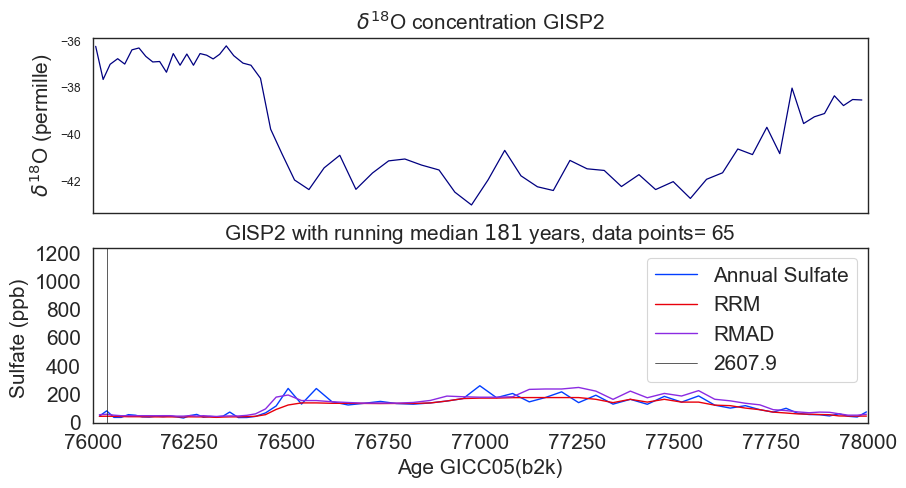

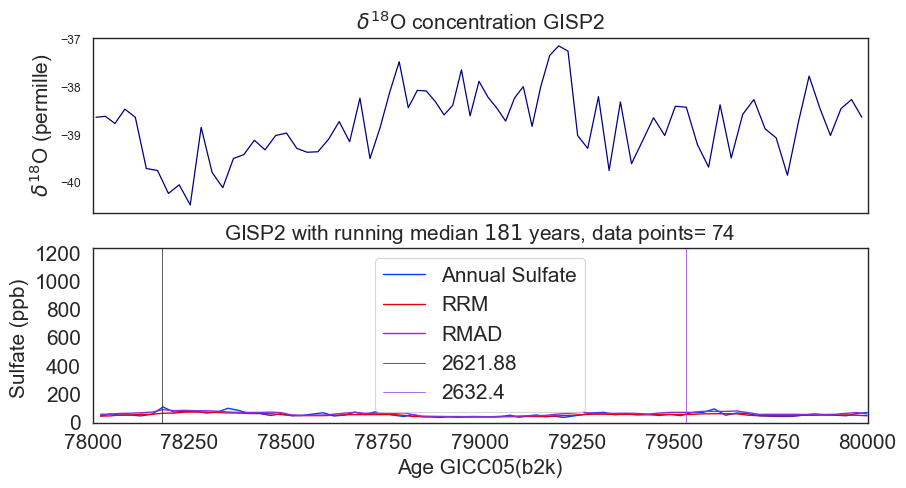

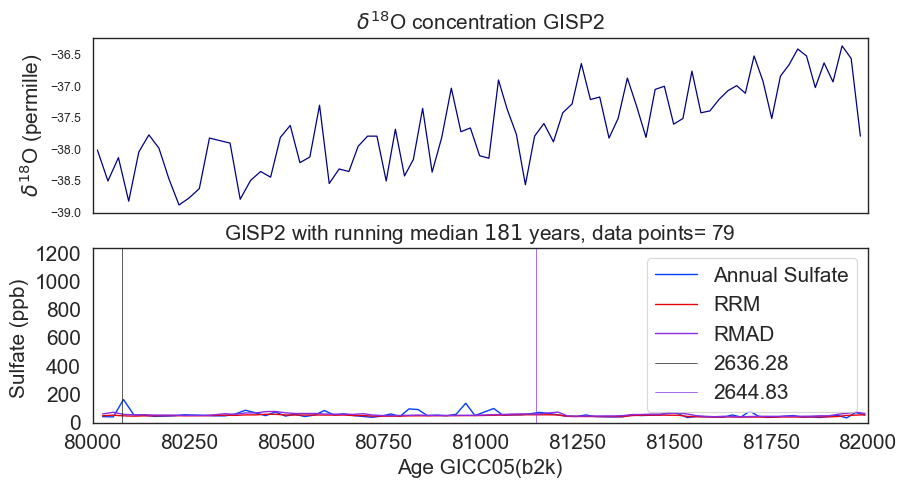

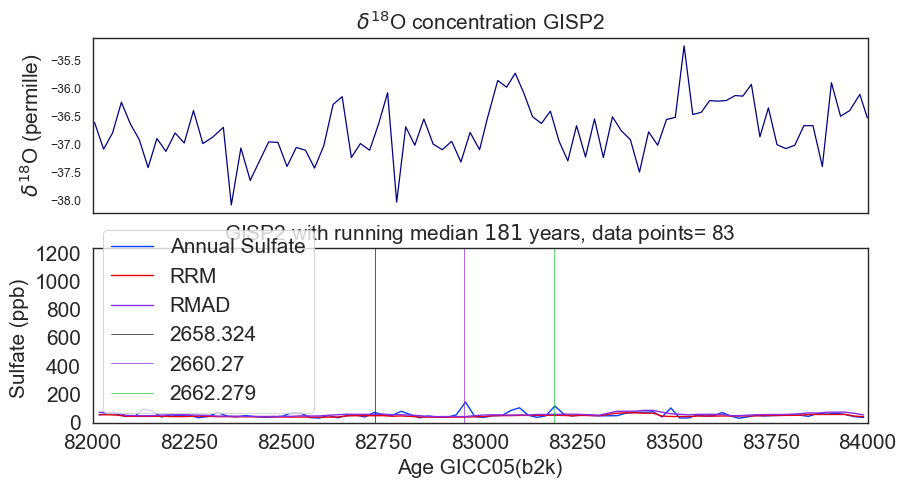

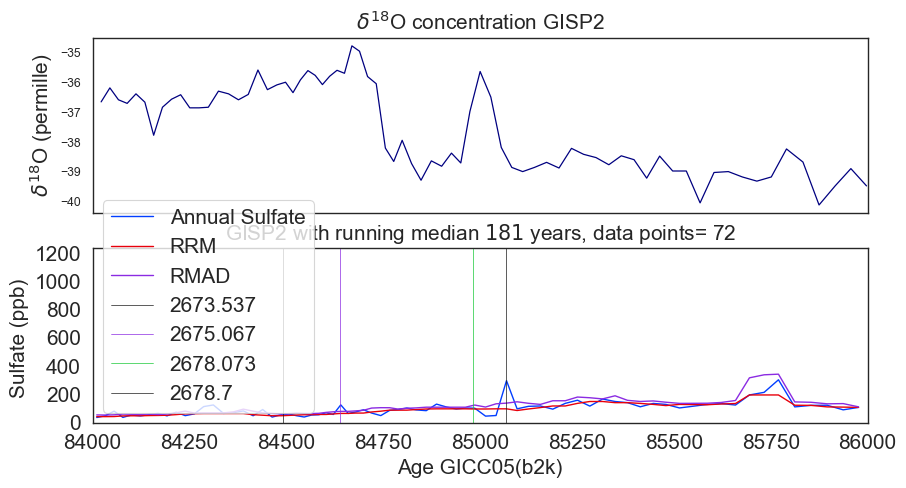

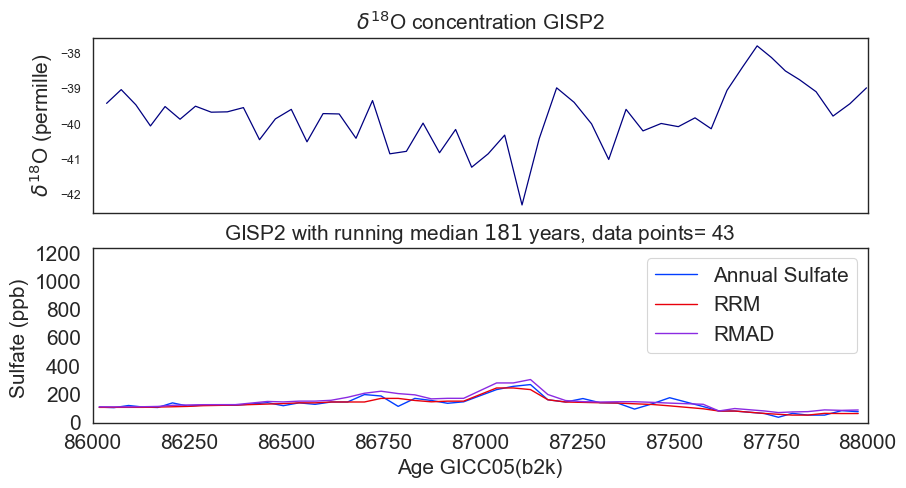

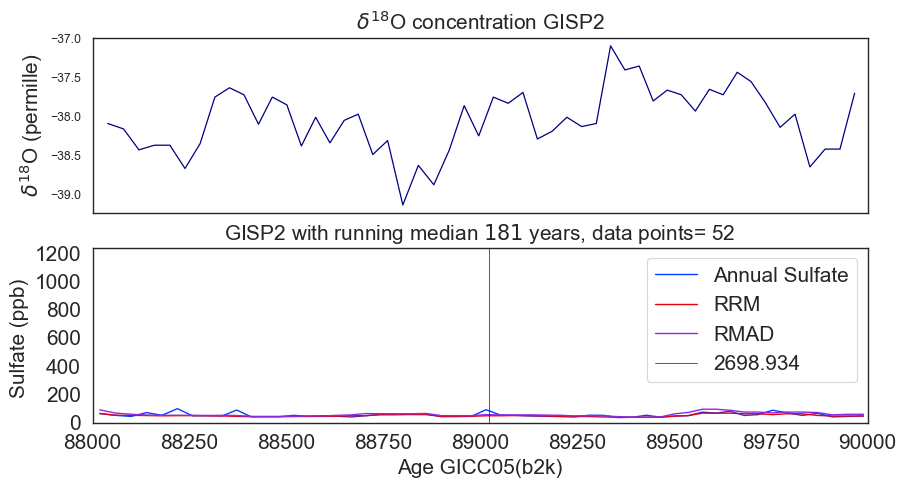

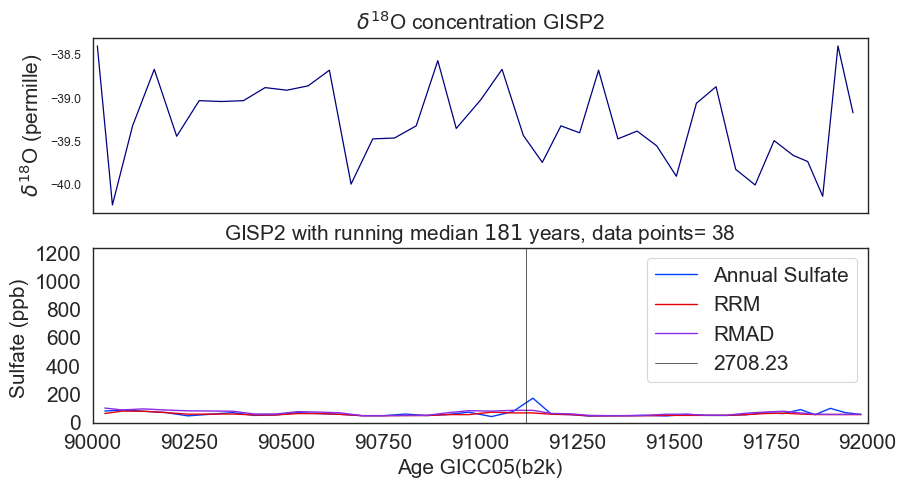

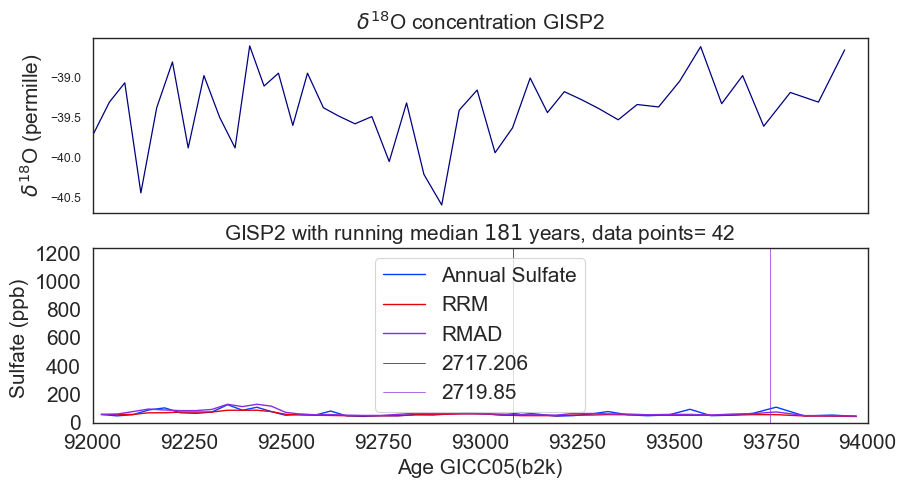

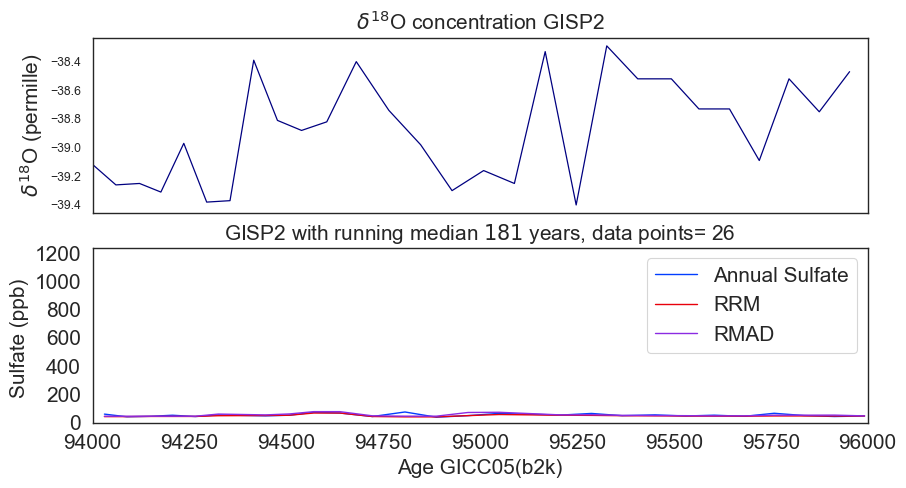

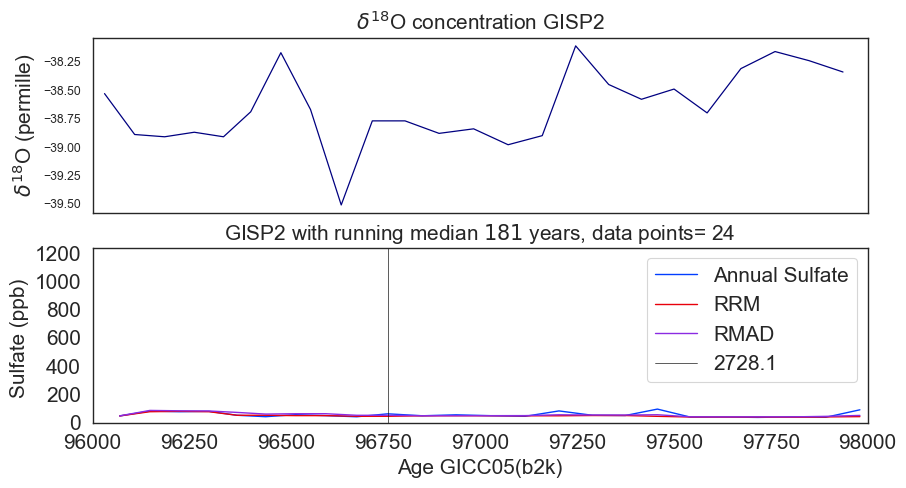

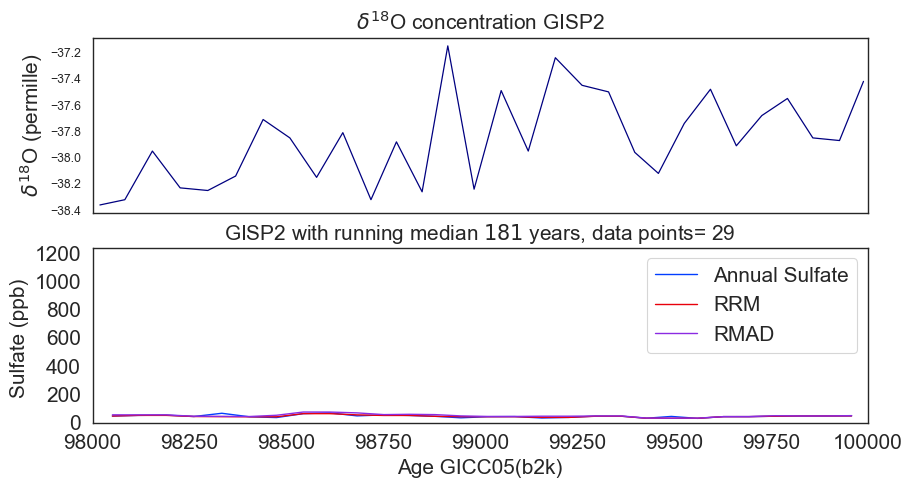

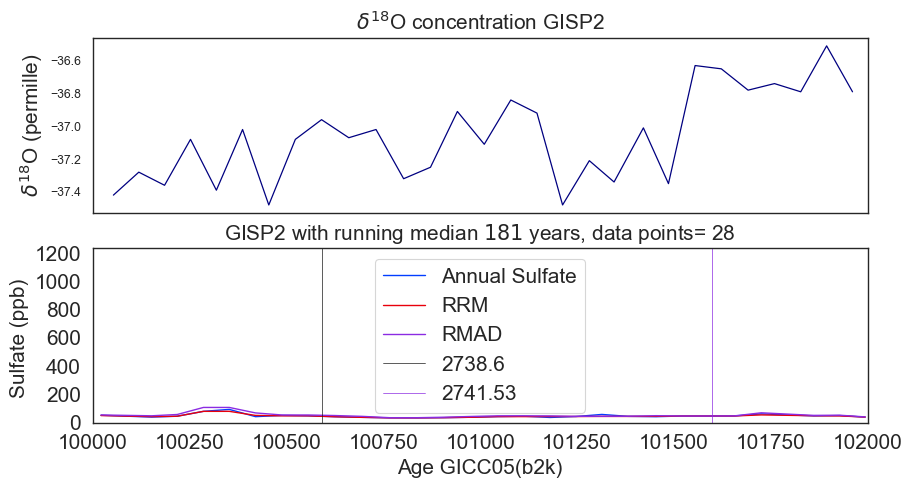

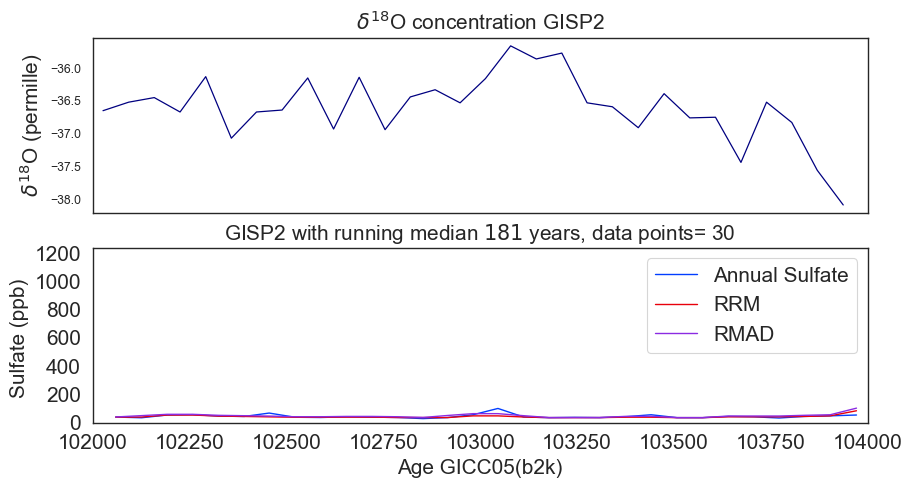

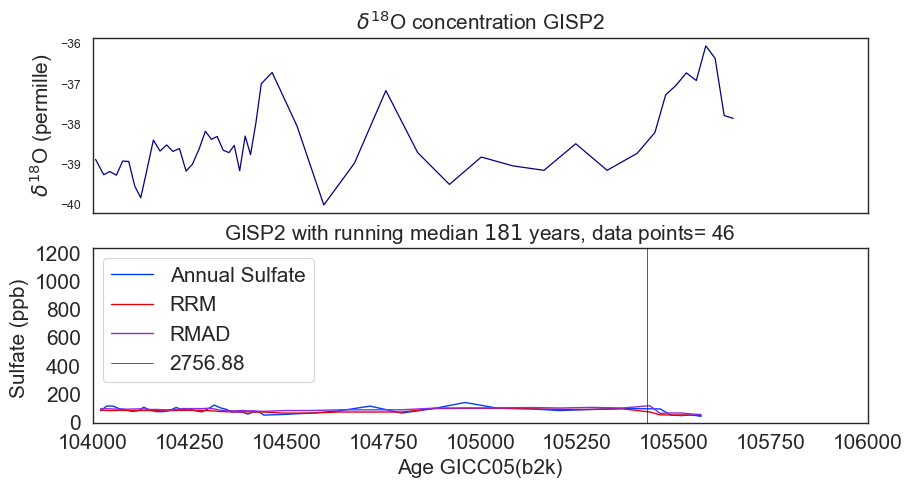

In [26]:
#%store -r GISP2_missing_depth
%store -r depth_bp_GISP2

#GISP2_missing_depth = np.array(GISP2_missing_depth)
data_points=[]
age_bp = np.interp(depth_bp_GISP2, GISP2_depth[lim_GISP2], GISP2_age)
#GISP2_missing_age = np.interp(GISP2_missing_depth, GISP2_depth, GISP2_age)
#GISP2_ECM_age = np.interp(GISP2_ECM_depth, GISP2_depth, GISP2_age)
age_bp_GISP2 = np.interp(depth_bp_GISP2[~np.isnan(depth_bp_GISP2)], GISP2_depth[lim_GISP2], GISP2_age)

for i in range(len(GISP2_age_list)-1):
    idx = np.where((GISP2_age >= GISP2_age_list[i]) & (GISP2_age <= GISP2_age_list[i+1]))
    GISP2_annual_s = GISP2_age[idx]
    GISP2_annual_sulfate_interp_s = GISP2_sulfate[idx]
    
    idx_all = np.where((GISP2_age >= GISP2_age_list[i]) & (GISP2_age <= GISP2_age_list[i+1]))
    
    GISP2_sulfate_count = len(GISP2_sulfate[idx_all])
    colors = ['k', 'm', 'g', 'k', 'm', 'g', 'k', 'm', 'g', 'k', 'm', 'g']
    
    data_points.append(GISP2_sulfate_count)
    
    idx_ox = np.where((GISP2_d18O_age >= GISP2_age_list[i]) & (GISP2_d18O_age <= GISP2_age_list[i+1]))
    
    if len(GISP2_annual_s) == 0:
        idx_all = np.where((GISP2_age > GISP2_age_list[i]) & (GISP2_age < GISP2_age_list[i+1]))
        idx_bp = []
        
    else:
        idx_all = np.where((GISP2_age > GISP2_age_list[i]) & (GISP2_age < GISP2_age_list[i+1]))
        idx_bp = np.where((age_bp_GISP2 < GISP2_annual_s[-1]) & (age_bp_GISP2 > GISP2_annual_s[0]))
    
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
    
    ax1.set_title('$\delta^{18}$O concentration GISP2', fontsize=15)
    ax1.plot(GISP2_d18O_age[idx_ox], GISP2_d18O[idx_ox], color='navy',linewidth=.9)
    ax1.set_ylabel('$\delta^{18}$O (permille)', fontsize=15)
    #ax1.set_ylim(-47,-31)
    
    ax2.plot(GISP2_age[idx], GISP2_sulfate[lim_GISP2][idx], linewidth=1, label = 'Annual Sulfate', color='b')
    ax2.plot(GISP2_age[idx], all_RRM_GISP2[:,3][idx], linewidth = 1, label = 'RRM', color='r')
    ax2.plot(GISP2_age[idx], all_RMAD_GISP2[:,3][idx], linewidth= 1, label = 'RMAD', color='m')
    #plt.plot(GISP2_annual_s, GISP2_RMAD[idx], linewidth=1, label = 'RMAD', color='gold')
    ax2.set_ylim(0,2500)
    ax2.set_xlabel('Age GICC05(b2k)', fontsize=15)
    ax2.set_ylabel('Sulfate (ppb) ', fontsize=15)
    ax2.set_ylim(0,np.nanmax(GISP2_sulfate,initial=250) + 250)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax2.set_xlim(GISP2_age_list[i], GISP2_age_list[i+1])
    ax2.set_title('GISP2 with running median $'+str(GISP2_filt)+'$ years, data points= ' + str(GISP2_sulfate_count), fontsize=15)
    if len(idx_bp) != 0:
        for j in range(len(age_bp[idx_bp])):
            ax2.axvline(x=age_bp_GISP2[idx_bp][j], ymin=0, ymax=1, color=colors[j], linewidth=.5, label = str(depth_bp_GISP2[~np.isnan(depth_bp_GISP2)][idx_bp][j]))
    if i == 20:
        plt.savefig('GISP2_' + str(GISP2_annual_s[-1])+ '_' + str(GISP2_annual_s[0]) + '_' + str(GISP2_filt) + '_RM.jpg', dpi=1000, bbox_inches='tight')
    ax2.legend(fontsize=15)
    plt.show()
    #else: 
        #continue

In [27]:
GISP2_filt_list = GISP2_filt*np.ones(len(GISP2_age_list))
print(tabulate({'Data res.': data_points, 'Interval1': GISP2_age_list[:-1], 'Interval2': GISP2_age_list[1:], 'Filter': GISP2_filt_list[:-1]}, headers="keys", tablefmt='fancy_grid'))

╒═════════════╤═════════════╤═════════════╤══════════╕
│   Data res. │   Interval1 │   Interval2 │   Filter │
╞═════════════╪═════════════╪═════════════╪══════════╡
│           0 │       10000 │       12000 │      181 │
├─────────────┼─────────────┼─────────────┼──────────┤
│         479 │       12000 │       14000 │      181 │
├─────────────┼─────────────┼─────────────┼──────────┤
│         327 │       14000 │       16000 │      181 │
├─────────────┼─────────────┼─────────────┼──────────┤
│         237 │       16000 │       18000 │      181 │
├─────────────┼─────────────┼─────────────┼──────────┤
│         215 │       18000 │       20000 │      181 │
├─────────────┼─────────────┼─────────────┼──────────┤
│         190 │       20000 │       22000 │      181 │
├─────────────┼─────────────┼─────────────┼──────────┤
│         185 │       22000 │       24000 │      181 │
├─────────────┼─────────────┼─────────────┼──────────┤
│         144 │       24000 │       26000 │      181 │
├─────────

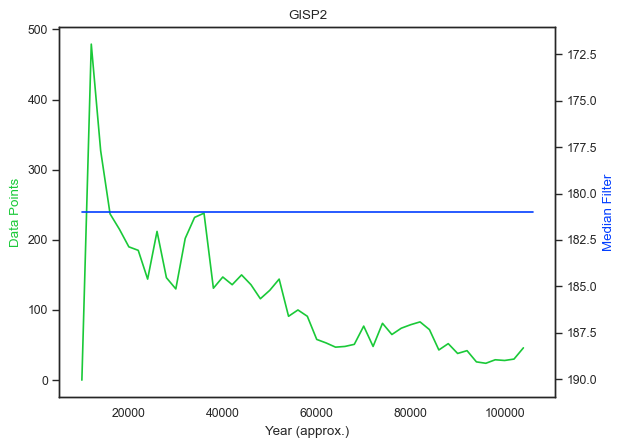

In [28]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(GISP2_age_list[:-1], data_points, 'g')
ax2.plot(GISP2_age_list, GISP2_filt_list, 'b')

ax1.set_xlabel('Year (approx.)')
ax1.set_ylabel('Data Points', color='g')
ax2.set_ylabel('Median Filter', color='b')
plt.title('GISP2')
plt.savefig('GISP2_data_points')
ax2.invert_yaxis()

plt.show()

### Sulfate Deposition

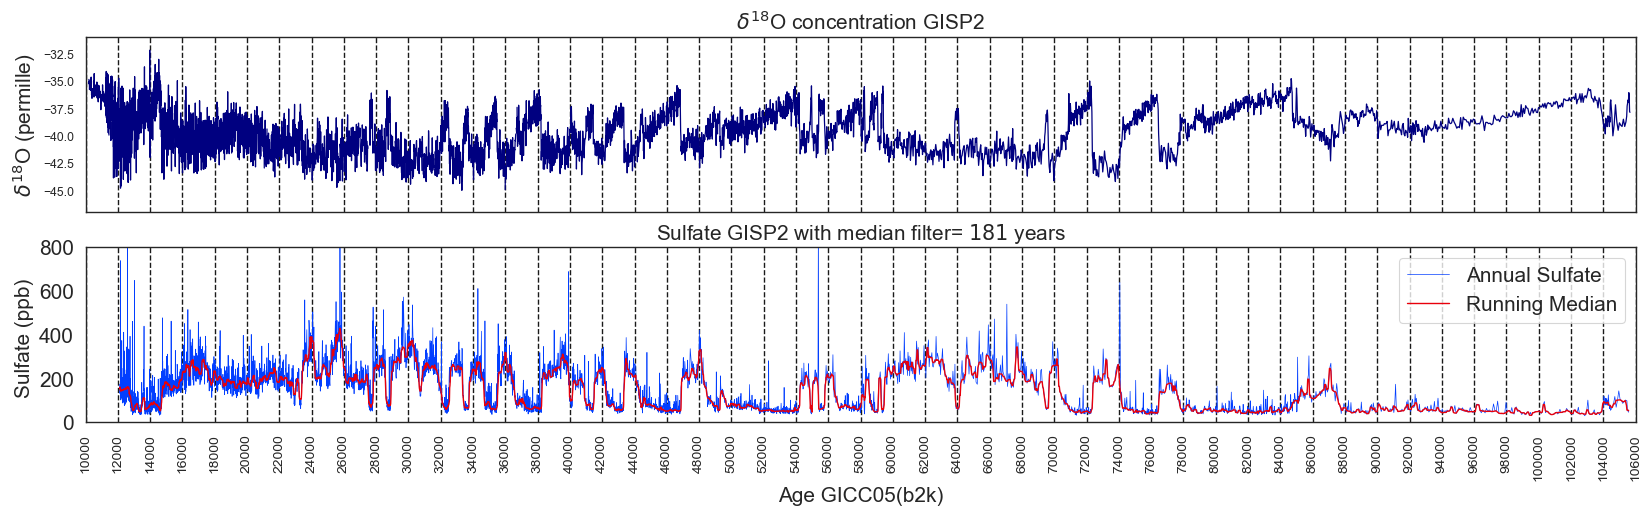

In [29]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(20,5), sharex=True)

label_vlines = np.arange(1,len(GISP2_age_list)+1,1)

GISP2_age_list_int = [int(x) for x in GISP2_age_list]

ax1.vlines(GISP2_age_list, -47,-31, color='k', linestyle='--', linewidth=1)

ax1.set_title('$\delta^{18}$O concentration GISP2', fontsize=15)
ax1.plot(GISP2_d18O_age, GISP2_d18O, color='navy', linewidth=.9)
ax1.set_ylabel('$\delta^{18}$O (permille)', fontsize=15)
ax1.set_ylim(-47,-31)
ax1.set_xlim(GISP2_annual[0], GISP2_annual[-1])

ax2.vlines(GISP2_age_list, 0,3000, color='k', linestyle='--', linewidth=1)

ax2.set_title('Sulfate GISP2 with median filter= $'+str(GISP2_filt)+'$ years', fontsize=15)
ax2.plot(GISP2_age, GISP2_sulfate[lim_GISP2], linewidth=.5, label = 'Annual Sulfate', color='b')
ax2.plot(GISP2_age, GISP2_RRM, linewidth = 1, label = 'Running Median', color='r')
#ax1.plot(GISP2_annual_s, GISP2_MAD[idx], linewidth=1, label = 'MAD', color='gold')
ax2.legend(fontsize=15, loc='best')
ax2.set_ylim(0,800)
ax2.set_xlabel('Age GICC05(b2k)', fontsize=15)
ax2.set_ylabel('Sulfate (ppb) ', fontsize=15)
plt.xticks(GISP2_age_list, GISP2_age_list_int, fontsize=10,rotation=90)
plt.yticks(fontsize=15)
plt.xlabel('Age GICC05(b2k)', fontsize=15)
#ax2.set_xlim(GISP2_age_list[i], GISP2_age_list[i+1])
plt.savefig('GISP2_' + str(GISP2_filt) + '_RM_d18O_intevals.jpg', dpi=1000, bbox_inches='tight')
plt.show()